In [1]:
import math

from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.chem import MolecularData
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from pyscf import gto, scf, mcscf

from helper_functions import *
from XBK_method import *
from QCC_method import *

import time
import statistics as st
from pprint import pprint

import sys
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install dwave-ocean-sdk
#!dwave setup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)

print("Finished")

Finished


In [2]:
#create molecule
name = 'HCONH2'
charge = 0
multiplicity = 1
basis = 'sto-6g'

bond_length = 1.1
geometry = get_molGeometry(name, bond_length)
    
molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

In [3]:
#run RHF calculations

start_time = time.time()
molecule = run_pyscf(molecule, run_scf=True)
end_time = time.time() - start_time

hf_energy = float(molecule.hf_energy)
hf_data = molecule._pyscf_data['scf']

print(hf_energy)
print(end_time)

-205.53387517069788
1.1842460632324219


In [4]:
#define active space
n_active_electrons = 2
n_active_orbitals = 3
occupied_indices, active_indices = get_active_space(molecule, n_active_electrons, n_active_orbitals)

#run CASCI calculations
casci_data = hf_data.CASCI(n_active_orbitals, n_active_electrons).run(verbose=False)
casci_energy = float(casci_data.e_tot)

print(casci_energy)

-205.54647301011377


In [5]:
#%%capture
#convert to fermionic Hamiltonian
molecular_H = molecule.get_molecular_hamiltonian(occupied_indices=occupied_indices, active_indices=active_indices)
if molecular_H[()] == None:
    molecular_H[()] = 0
fermionic_H = get_fermion_operator(molecular_H)

#add penalty term to ensure correct number of electrons in ground state
weight = 5
penalty_term = FermionOperator('', n_active_electrons)

for i in range(molecular_H.n_qubits):
    penalty_term += FermionOperator(str(i)+'^ '+str(i), -1)
fermionic_H += weight*penalty_term**2

f_operators = list(fermionic_H.get_operators())
#print(len(f_operators))
#print(fermionic_H)

In [6]:
#%%capture
#convert to Pauli operator Hamiltonian
binary_code = bravyi_kitaev_code(molecular_H.n_qubits)
qubit_H = binary_code_transform(fermionic_H, binary_code)
qubit_H.compress()

#apply symmetry reductions and calculate minimum eigenvalue (should be equal to CASCI energy)
sectors = taper_qubits(qubit_H)
qubit_H, min_eigenvalue = sector_with_ground(sectors)
m = count_qubits(qubit_H)

print(min_eigenvalue, '\n')
operators = list(qubit_H.get_operators())
#print(len(operators))
#print(m)

-205.5464730101143 



In [1]:
#set sampler to perform the annealing
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()

In [8]:
### QCC method ###

def QCC_m(angle_folds=3, amplitude_folds=1, num_cycles=10, num_samples=1000, strength=1e3):
    #set number of Bloch angle and entangler amplitude foldings
    #angle_folds = 3
    #amplitude_folds = 1
#    print("Angle folds: ", angle_folds, "\nAmplitude Folds: ", amplitude_folds, 
#          "\nNum cycles: ", num_cycles, "\nStrength: ", strength)

    #create dictionary of QubitOperator entanglers
    entanglers = {'IYZI': QubitOperator('Y1 Z2'), 'IZYI': QubitOperator('Z1 Y2'),
                  'IXYI': QubitOperator('X1 Y2'), 'IYXI': QubitOperator('Y1 X2')}

    #run QCC method
    sampler = DWaveSampler()
    sampler = EmbeddingComposite(sampler)

    QCC_energy, variables, response = QCC(qubit_H, entanglers, angle_folds, amplitude_folds, sampler,
                                num_cycles=num_cycles, num_samples=num_samples, strength=strength)
    
    #print(response.info["timing"])
    return QCC_energy, response.info["timing"]

#print("Finished.")
#print(QCC_energy)
#print(variables)

In [10]:
### Test method ###

def Test(QPU=False, num_cycles=[3,4,5,6,7], num_samples=[100,300,500,700,900], strengths=[1000], runs=5, angle_folds=3, amplitude_folds=1):
    results = []
    for cycle in num_cycles:
        for sample in num_samples:
            for strength in strengths:
                this_time = []
                this_energy = []
                if QPU:
                    for i in range(0,runs):
                        response = QCC_m(3, 1, cycle, sample, strength)
                        energy = response[0]
                        print("Energy: ", energy)
                        this_energy.append(energy - hf_energy)
                        this_time.append(response[1]['qpu_access_time'])
                        print("Time: ", response[1]['qpu_access_time'])
                        print("Run ", i, "completed.")
                    results.append([cycle, sample, strength, st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
                    print("Result ", cycle, sample, strength, " finished.")
                else:
                    for i in range(0,runs):
                        start_time = time.time()
                        energy = QCC_m(3, 1, cycle, sample, strength)
                        print(energy)
                        end_time = time.time() - start_time
                        this_energy.append(energy - hf_energy)
                        this_time.append(end_time)
                        print("Run ", i, "completed.")
                    results.append([cycle, sample, strength, st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
                    print("Result ", cycle, sample, strength, " finished.")
    return results

In [11]:
def plot_heatmap(results, xvar="num_samples", yvar="num_cycles", const="str"):
    titles=["Average energy error for number of samples vs number of cycles",
           "Standard deviation in energy error for number of samples vs number of cycles",
           "Average time for number of samples vs number of cycles"]

    for i in range(3,6):
        data = list(chunks(([result[i] for result in results[0::tot_str]]),tot_samples))

        vmax = max_value(data)
        if(i!=5):
            vmax/=10
        vmin = min_value(data)

        ax = sns.heatmap(data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)
        plt.xlabel("Number of samples")
        plt.ylabel("Number of cycles")
        plt.title(titles[i-3])
        plt.show()

In [13]:
num_cycles=range(1,8)
num_samples=range(50,1050,100)
strengths=[1000]
runs=5

tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_samples)

7
10


In [14]:

results = Test(num_cycles, num_samples, strengths, runs)
pprint(results)

Result  1 50 1000  finished.
Result  1 150 1000  finished.
Result  1 250 1000  finished.
Result  1 350 1000  finished.
Result  1 450 1000  finished.
Result  1 550 1000  finished.
Result  1 650 1000  finished.
Result  1 750 1000  finished.
Result  1 850 1000  finished.
Result  1 950 1000  finished.
Result  2 50 1000  finished.
Result  2 150 1000  finished.
Result  2 250 1000  finished.
Result  2 350 1000  finished.
Result  2 450 1000  finished.
Result  2 550 1000  finished.
Result  2 650 1000  finished.
Result  2 750 1000  finished.
Result  2 850 1000  finished.
Result  2 950 1000  finished.
Result  3 50 1000  finished.
Result  3 150 1000  finished.
Result  3 250 1000  finished.
Result  3 350 1000  finished.
Result  3 450 1000  finished.
Result  3 550 1000  finished.
Result  3 650 1000  finished.
Result  3 750 1000  finished.
Result  3 850 1000  finished.
Result  3 950 1000  finished.
Result  4 50 1000  finished.
Result  4 150 1000  finished.
Result  4 250 1000  finished.
Result  4 350 

[[10.379996378315223, 6.170610147663643, 6.12700660602855, 3.213629651516345, 24.047829363644958, 9.19962644935436, 4.867406655028714, 9.204015373064573, 3.161703000350059, 3.564162352571981], [0.7260397763995172, 0.12734435703455915, 0.03203428979027763, 0.0823386115327196, 0.017456538263610356, 3.0755877795468733, 6.268233098489833, 0.03543399961341152, 3.0889425444867413, 0.04173654462061336], [0.09957756784129401, 0.037584528532130436, 0.00834911443376427, 0.048479362569884187, 0.14572543910322225, 3.0794752806934014, 0.07851599713172278, 0.13884170038941762, 0.05865621372209375, 0.05814742337529992], [0.2436469588384682, -0.011571711827167519, 0.019718077707472047, 0.026296664464422293, 0.0484406153423663, 0.08571361546487992, 0.04843960242429261, 0.026214113694692287, 0.05813534161857774, 0.01416848819640677], [-0.005031498028296255, 1.9891460907164913, -0.011571077503361948, 0.01753902271589709, -0.010547129817172162, -0.01105775687178152, -0.010031179971741721, -0.0115711872248

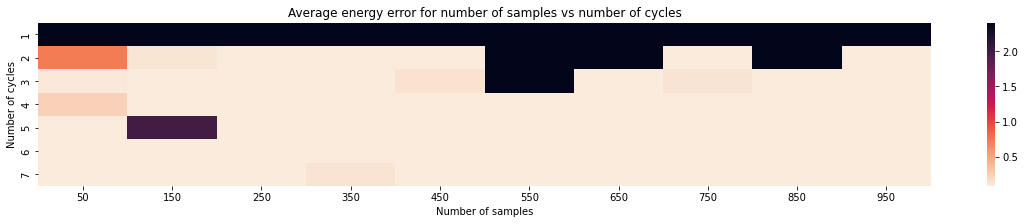

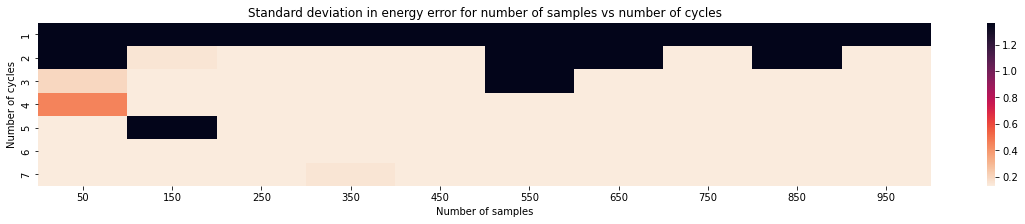

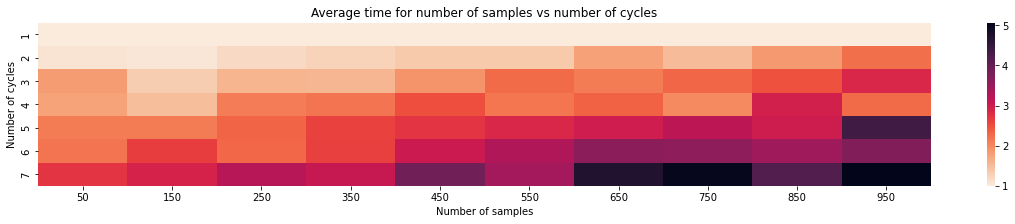

In [17]:
#import sys
#!{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])

def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

# num cycles vs num samples
# energy mean error

mean_energy_data = list(chunks(([result[3] for result in results[0::tot_str]]),tot_samples))

print(mean_energy_data)

vmax = max_value(mean_energy_data)/10
vmin = min_value(mean_energy_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(mean_energy_data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Number of samples")
plt.ylabel("Number of cycles")
plt.title("Average energy error for number of samples vs number of cycles")
plt.show()

# num cycles vs num samples
# energy stdev
stdev_data = list(chunks(([result[4] for result in results[0::tot_str]]),tot_samples))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)/10
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Number of samples")
plt.ylabel("Number of cycles")
plt.title("Standard deviation in energy error for number of samples vs number of cycles")
plt.show()

# num cycles vs num samples
# average time
stdev_data = list(chunks(([result[5] for result in results[0::tot_str]]),tot_samples))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)

plt.xlabel("Number of samples")
plt.ylabel("Number of cycles")
plt.title("Average time for number of samples vs number of cycles")
plt.show()

In [40]:
num_cycles=range(1,8)
num_samples=[1000]
strengths=range(10,1010,100)
tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_str)

7
10


In [41]:
results = Test(num_cycles, num_samples, strengths)
pprint(results)

Result  1 1000 10  finished.
Result  1 1000 110  finished.
Result  1 1000 210  finished.
Result  1 1000 310  finished.
Result  1 1000 410  finished.
Result  1 1000 510  finished.
Result  1 1000 610  finished.
Result  1 1000 710  finished.
Result  1 1000 810  finished.
Result  1 1000 910  finished.
Result  2 1000 10  finished.
Result  2 1000 110  finished.
Result  2 1000 210  finished.
Result  2 1000 310  finished.
Result  2 1000 410  finished.
Result  2 1000 510  finished.
Result  2 1000 610  finished.
Result  2 1000 710  finished.
Result  2 1000 810  finished.
Result  2 1000 910  finished.
Result  3 1000 10  finished.
Result  3 1000 110  finished.
Result  3 1000 210  finished.
Result  3 1000 310  finished.
Result  3 1000 410  finished.
Result  3 1000 510  finished.
Result  3 1000 610  finished.
Result  3 1000 710  finished.
Result  3 1000 810  finished.
Result  3 1000 910  finished.
Result  4 1000 10  finished.
Result  4 1000 110  finished.
Result  4 1000 210  finished.
Result  4 1000

[[-1.0393186189531831, 4.005189796843439, 6.161568469617447, 0.1268318719142883, 9.227997732890032, 6.2089050611698955, 9.178194492570725, 9.192289086241322, 6.252475575289242, 6.599498053266103], [-0.6689204053113315, 6.1478350174532865, 0.06582759361040758, 6.191715054231423, 0.04990769612045938, 0.09125003808144924, 0.17575005250324124, 0.06440301205580568, 0.058729134684796236, 3.0852905610735943], [-11.968312270987298, -0.0013501082198160929, 0.04122905132822439, 0.013857668162341952, 0.03152323685640681, 0.037853162964125886, 0.1084513949826544, 0.013648161284032767, 0.026214028730424842, 0.02621512349720092], [-2.7343509972190474, -0.0110578740678136, 0.048651936545462605, 0.06784675325466764, 0.04787362794009482, 0.02621506657301893, -0.010544700503709236, -0.01105811733436326, 0.03152096097397248, -0.01054556818712058], [-14.313446364051009, 0.035917630275031344, 0.06682058251167859, 0.06733411380951679, -0.010555264694306742, 0.13264890614514685, 0.007835283751734323, -0.0105

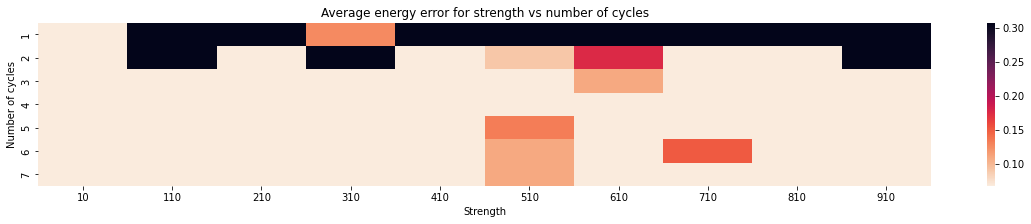

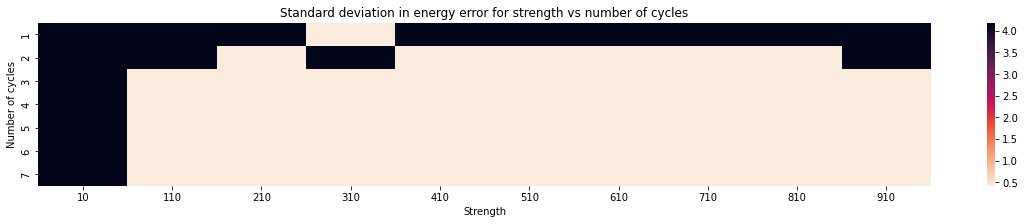

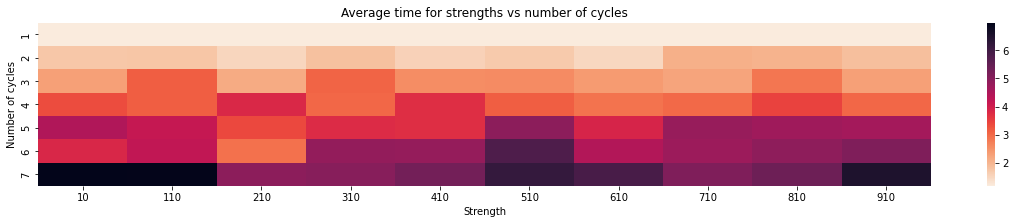

In [43]:
#import sys
#!{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])

def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

# num cycles vs num samples
# energy mean error

mean_energy_data = list(chunks(([result[3] for result in results[0::1]]),tot_str))

print(mean_energy_data)

vmax = max_value(mean_energy_data)/30
vmin = min_value(mean_energy_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(mean_energy_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Average energy error for strength vs number of cycles")
plt.show()

# num cycles vs num samples
# energy stdev
stdev_data = list(chunks(([result[4] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)/30
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Standard deviation in energy error for strength vs number of cycles")
plt.show()

# num cycles vs num samples
# average time
stdev_data = list(chunks(([result[5] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_cycles, cmap=cmap)

plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Average time for strengths vs number of cycles")
plt.show()

In [13]:
num_cycles=[4]
num_samples=range(10,1010,100)
strengths=range(10,10010,1000)
tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_samples)
print(tot_str)

1
10
10


In [14]:
results = Test(num_cycles, num_samples, strengths)
pprint(results)

Result  4 10 10  finished.
Result  4 10 1010  finished.
Result  4 10 2010  finished.
Result  4 10 3010  finished.
Result  4 10 4010  finished.
Result  4 10 5010  finished.
Result  4 10 6010  finished.
Result  4 10 7010  finished.
Result  4 10 8010  finished.
Result  4 10 9010  finished.
Result  4 110 10  finished.
Result  4 110 1010  finished.
Result  4 110 2010  finished.
Result  4 110 3010  finished.
Result  4 110 4010  finished.
Result  4 110 5010  finished.
Result  4 110 6010  finished.
Result  4 110 7010  finished.
Result  4 110 8010  finished.
Result  4 110 9010  finished.
Result  4 210 10  finished.
Result  4 210 1010  finished.
Result  4 210 2010  finished.
Result  4 210 3010  finished.
Result  4 210 4010  finished.
Result  4 210 5010  finished.
Result  4 210 6010  finished.
Result  4 210 7010  finished.
Result  4 210 8010  finished.
Result  4 210 9010  finished.
Result  4 310 10  finished.
Result  4 310 1010  finished.
Result  4 310 2010  finished.
Result  4 310 3010  finished

NameError: name 'pprint' is not defined

[[-62.84094692449517, 0.13610448409858122, 0.1977676849299712, 0.017259599045468123, 0.13942616722019352, 0.08903080990825743, 0.07396178049788774, 3.331296652996065, 0.059669129245997966, 3.203786883338438], [-83.08954420448413, -0.005369818922514469, 0.03397242108880505, 0.085120121294716, -0.007657285432247818, 0.016649844542229175, 0.012691194422626496, 0.07145277373314798, -0.005168768008621783, -0.005903593941508234], [-83.88122093275936, -0.008935625253394619, 0.0025841398205045606, 0.0073970494308412075, 0.023756451344200968, 0.013633060139221697, 0.04091956035521775, -0.005917410216676444, 0.010157243602992593, 0.05449707133051902], [-72.17211310949875, 0.05530146510395184, -0.005292692368999497, 0.040251152448439596, 0.11131362158161551, 0.05323144981925339, 0.010360211772461981, 0.0689178908458814, 0.006493014677511155, -0.010033750093458593], [-46.916619570589745, 0.025192072095200045, 0.03569513587103188, -0.008776370367883146, -0.006803304866804183, 0.03381559289813936, 0

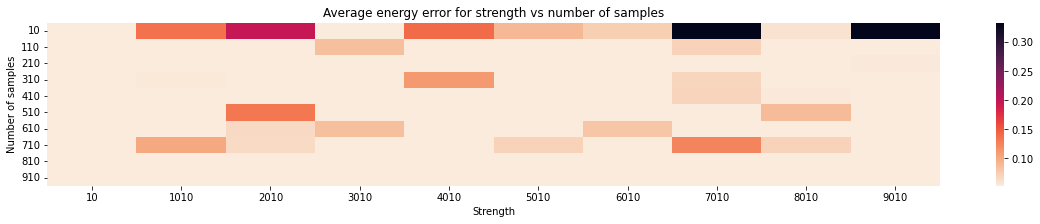

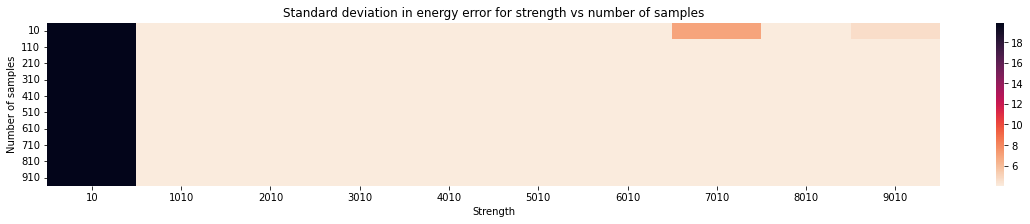

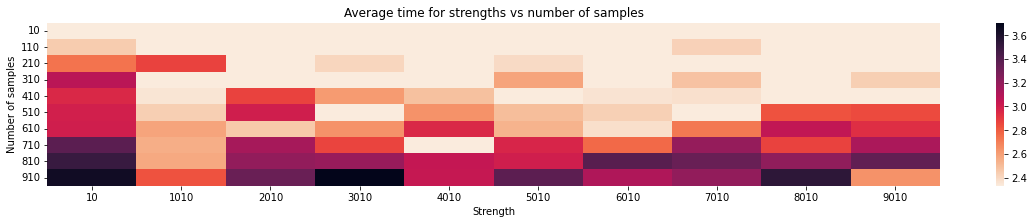

In [16]:
#import sys
#!{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])

def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

# num cycles vs num samples
# energy mean error

mean_energy_data = list(chunks(([result[3] for result in results[0::1]]),tot_str))

print(mean_energy_data)

vmax = max_value(mean_energy_data)/10
vmin = min_value(mean_energy_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(mean_energy_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_samples, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of samples")
plt.title("Average energy error for strength vs number of samples")
plt.show()

# num cycles vs num samples
# energy stdev
stdev_data = list(chunks(([result[4] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)/10
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_samples, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of samples")
plt.title("Standard deviation in energy error for strength vs number of samples")
plt.show()

# num cycles vs num samples
# average time
stdev_data = list(chunks(([result[5] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_samples, cmap=cmap)

plt.xlabel("Strength")
plt.ylabel("Number of samples")
plt.title("Average time for strengths vs number of samples")
plt.show()

In [20]:
num_cycles=range(2,5)
num_samples=range(150,400,25)
strengths=[1000]
runs=10

tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_samples)

3
10


In [21]:
results = Test(num_cycles, num_samples, strengths)
pprint(results)

Result  2 150 1000  finished.
Result  2 175 1000  finished.
Result  2 200 1000  finished.
Result  2 225 1000  finished.
Result  2 250 1000  finished.
Result  2 275 1000  finished.
Result  2 300 1000  finished.
Result  2 325 1000  finished.
Result  2 350 1000  finished.
Result  2 375 1000  finished.
Result  3 150 1000  finished.
Result  3 175 1000  finished.
Result  3 200 1000  finished.
Result  3 225 1000  finished.
Result  3 250 1000  finished.
Result  3 275 1000  finished.
Result  3 300 1000  finished.
Result  3 325 1000  finished.
Result  3 350 1000  finished.
Result  3 375 1000  finished.
Result  4 150 1000  finished.
Result  4 175 1000  finished.
Result  4 200 1000  finished.
Result  4 225 1000  finished.
Result  4 250 1000  finished.
Result  4 275 1000  finished.
Result  4 300 1000  finished.
Result  4 325 1000  finished.
Result  4 350 1000  finished.
Result  4 375 1000  finished.
[[2,
  150,
  1000,
  0.06767910508610271,
  0.1262793166435389,
  1.7365950107574464,
  0.582619389

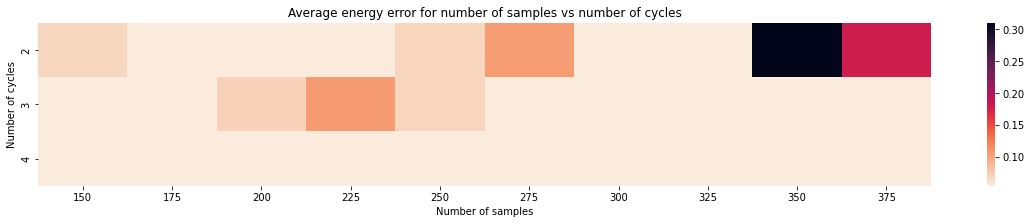

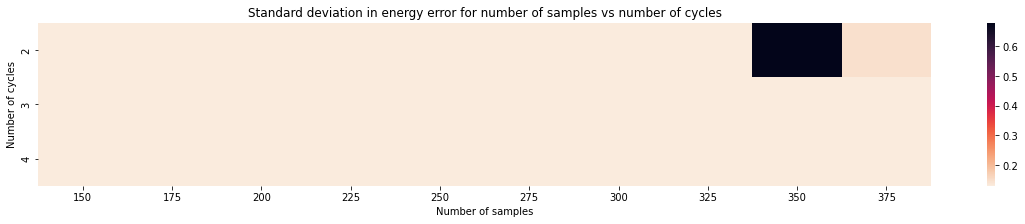

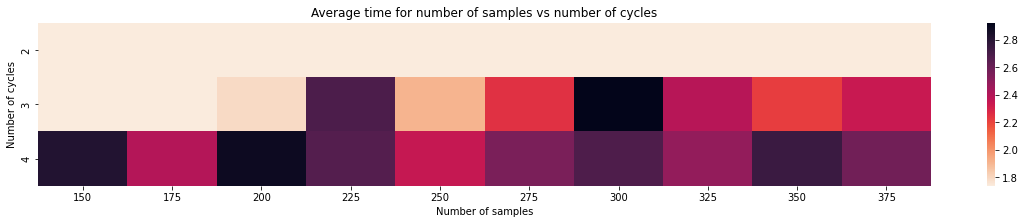

In [40]:


plot_heatmap(results)